In [2]:
import numpy as np
from PIL import Image
import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd

from skimage import measure
from skimage import filters
from skimage.filters import threshold_otsu

In [3]:
# Parameters
intensity_quantile_cutoff = 0.95;
sigma_gaussian_filter     = 5;
size_quantile_connected_components_include = 0.95;
pad_cell_border = 20;

In [4]:
#filename      = "../../ProteinData_ttx_1hr_2/AHA_2_MMStack_Pos0.ome_locs_render_driftcor_filter_render_pix0.02X6f20";
#filename = "../MikeData/EGFR-P1-ATTO655_cell_3_MMImages.ome_locs_render"
#filename = "../../MikeData/EGFR-P1-ATTO655_cell_2_MMImages.ome_locs_render_al_linked1sigma"
filename = '../../AnalysisDataOrganized/Mike_190516_EGFR-P1-ATTO655_cell_2_MMImages.ome_locs_render_al_linked1sigma/Output/heatmap_XC_H.txt'

In [7]:
H = np.loadtxt(filename);
#X = np.loadtxt(filename+"_heatmap_X.txt");
#Y = np.loadtxt(filename+"_heatmap_Y.txt");

In [8]:
H.shape

(1000, 1000)

In [9]:
im_arr = H;

In [10]:
#im_arr = ((H/np.max(H))*255).astype(np.uint8)

In [11]:
#im = Image.open(filename)
#im_arr = np.array(im);

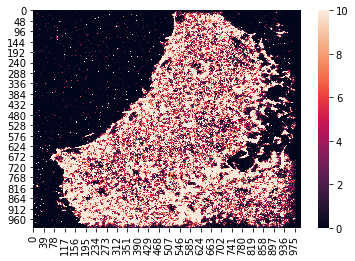

In [12]:
sns.heatmap(H,vmin=0,vmax=10);

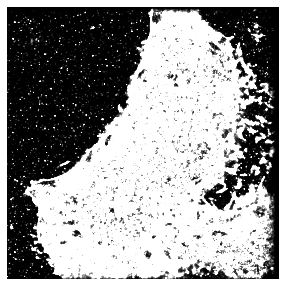

In [14]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(H,cmap='gray',vmax=5);
ax.axis('off');
ax.set_aspect(1)
#plt.savefig(outputfolder+name+'image.pdf')

# Intensity cutoff at X% quantile

In [15]:
H[H > np.quantile(H,intensity_quantile_cutoff)] = np.quantile(H,intensity_quantile_cutoff);

## Gaussian Filter

In [16]:
g_img = filters.gaussian(im_arr,sigma=sigma_gaussian_filter)

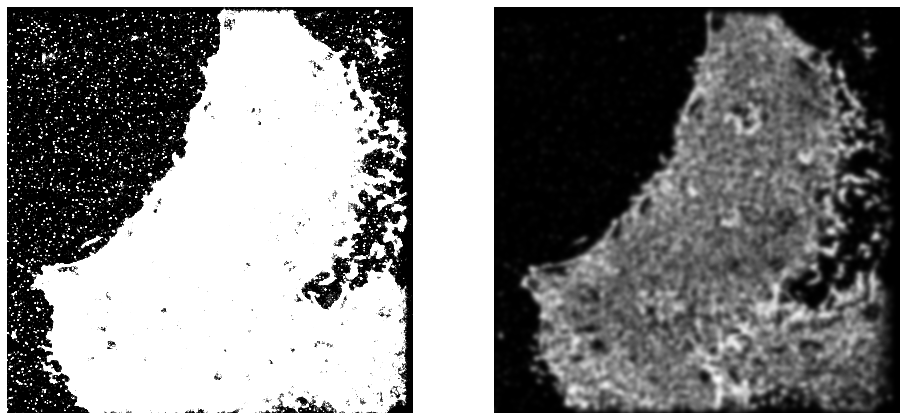

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(im_arr,cmap='gray',vmin=0,vmax=1)
ax[0].axis('off')
ax[1].imshow(g_img,cmap='gray')
ax[1].axis('off')
plt.savefig(filename+'_step_1_GaussianFilter.pdf')

## Thresholding

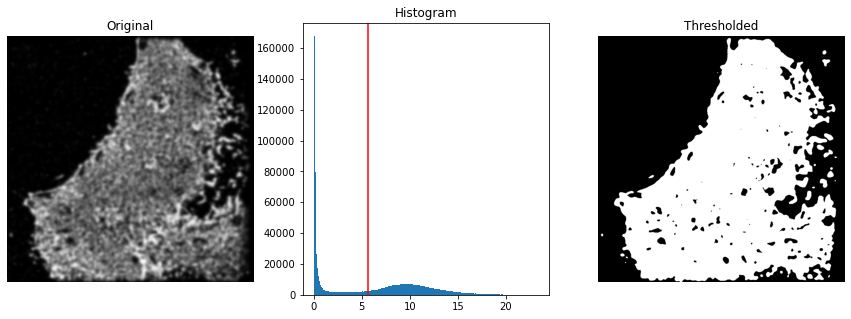

In [18]:
#g_img2 = filters.gaussian(g_img,sigma=5)
image  = g_img
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.savefig(filename+'_step_2_Thresholding.pdf')

In [19]:
labels = measure.label(binary);

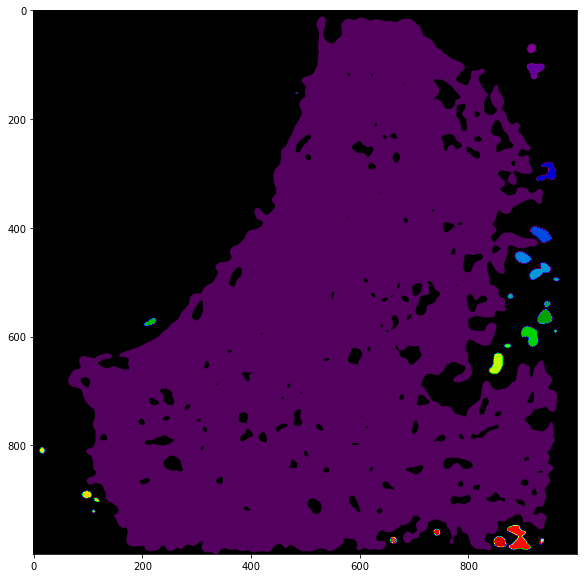

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(labels, cmap='nipy_spectral');
plt.savefig(filename+'_step_3_Components.pdf')

# Decide which areas to include

In [22]:
labels_noNoise = (labels>0);

H = (labels>0);
for i in np.arange(pad_cell_border):
    H[1:-1,1:-1] = (H[1:-1,1:-1]) | (H[:-2,1:-1]) | (H[2:,1:-1]) | (H[1:-1,:-2]) | (H[1:-1,2:]);
    
im_noise = (1-H);    

In [23]:
df_lab = pd.DataFrame();
df_lab['labels'] = (labels[labels>0]).flatten()
df_lab['index1'] = df_lab.index
labG = df_lab.groupby(by='labels');

In [24]:
print(labG.count().idxmax())

index1    1
dtype: int64


In [25]:
im_signal = np.zeros_like(H,dtype=np.bool_);
im_signal[labels==(labG.count().idxmax())['index1']] = True;

In [ ]:
#size = [];
#label = [];
#for l in np.unique(labels):
#    size.append(np.sum(labels==l));
#    label.append(l);
#    
#df = pd.DataFrame();
#df["size"]  = size;
#df["label"] = label;
#df = df.sort_values('size',ignore_index=True,ascending=False)
#
#df['include'] = False;
#mark = (df['size'] >= np.quantile(df['size'],\
#size_quantile_connected_components_include))&(df['label']!=0)
#df.loc[mark,'include'] = True;
#
#im_signal = np.zeros_like(H,dtype=np.bool);
#for l in np.unique(df.loc[df['include']==True,'label']):
#    print(l)
#    im_signal[labels==l] = True;

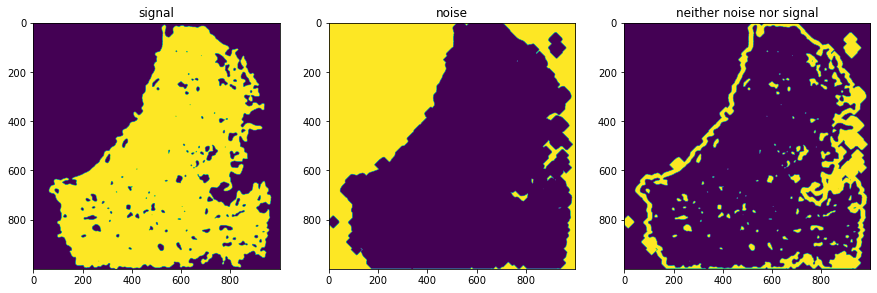

In [26]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].imshow(im_signal);
axs[0].set_title('signal');
axs[1].imshow(im_noise);
axs[1].set_title('noise');
axs[2].imshow((im_noise==0)*(im_signal==0));
axs[2].set_title('neither noise nor signal');
plt.savefig(filename+'_Step4_Mask.pdf')

In [ ]:
np.savetxt(filename+"_heatmap_mask_signal.txt",im_signal,fmt="%d");
np.savetxt(filename+"_heatmap_mask_noise.txt",im_noise,fmt="%d");